**NOTE: You need to run the whole noteboot from the beginning 
to the end every time you change the settings, mostly.**

In [1]:
# Param settings
TOTAL_TIME = 200000
ACTION_NUM = 10
INIT_Q = 0
Q_INC_VAR = 0.01
SAMPLE_NUM = 100

# Modelling
We geneate $q_*$ values throughout the lifetime offline as below, initially with **equal** values and then take random walks with **normal** increments. This is a nonstationary multi-armed bandit problem model.

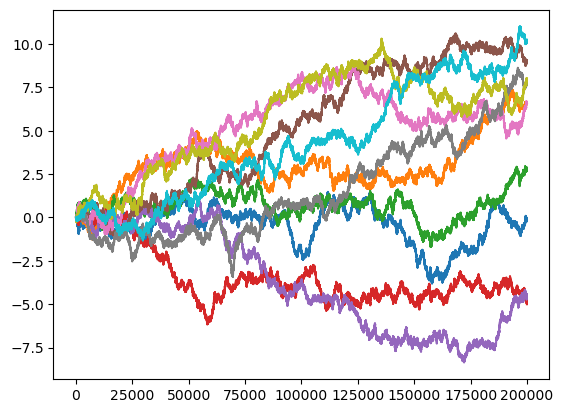

In [2]:
import numpy as np
from matplotlib import pyplot as plt

q_all = np.zeros((TOTAL_TIME+1, ACTION_NUM))
q_all[0] = np.linspace(INIT_Q,INIT_Q,ACTION_NUM)
np.random.shuffle(q_all[0])

for t in range(1, TOTAL_TIME+1):
    q_inc = np.random.normal(scale=Q_INC_VAR,size=(1,ACTION_NUM))
    q_all[t] = q_all[t-1] + q_inc
    
q_best = np.argmax(q_all, axis=1)

plt.plot(np.linspace(0,TOTAL_TIME, TOTAL_TIME+1),q_all)

# Learning
We take the learning process, with *sample-average method* or *constant step-size parameter method* as action-value method in parallel, and benchmark the outcomes of **average reward** and **rate of optimal action** for comparison.

In [3]:
import random
import math

cndt = [1/1024, 1/512, 1/256, 1/128, 1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1, 2, 4, 8, 16]
performance_log = [[],[],[],[]]

In [4]:
performance_log[0] = []
for eps in cndt:
    if eps >= 1:
        performance_log[0].append(np.NaN)
        continue
    Q = np.linspace(0,0,ACTION_NUM)
    is_explore = map(lambda x: True if x < eps else False, [random.random() for i in range(TOTAL_TIME)])
    R_sum = 0
    R_log = np.zeros(TOTAL_TIME+1)
    for t in range(1, TOTAL_TIME+1):
        A = random.randrange(0, ACTION_NUM) if next(is_explore) else np.argmax(Q)
        R = np.random.normal(loc=q_all[t][A])
        Q[A] += 0.1 * (R - Q[A])
        R_sum += R
        R_log[t] = R_sum/t
    performance_log[0].append(sum(R_log[-TOTAL_TIME//2:-1])/len(R_log[-TOTAL_TIME//2:-1]))

In [5]:
performance_log[1] = []
for q0 in cndt:
    p_sum = 0
    for i in range(SAMPLE_NUM):
        Q = np.linspace(q0,q0,ACTION_NUM)
        R_sum = 0
        R_log = np.zeros(TOTAL_TIME+1)
        for t in range(1, TOTAL_TIME+1):
            A = np.argmax(Q)
            R = np.random.normal(loc=q_all[t][A])
            Q[A] += 0.1 * (R - Q[A])
            R_sum += R
            R_log[t] = R_sum/t
        p_sum += sum(R_log[-TOTAL_TIME//2:-1])/len(R_log[-TOTAL_TIME//2:-1])
    
    performance_log[1].append(p_sum/100)

In [6]:
performance_log[2] = []

for c in cndt:
    p_sum = 0
    for i in range(SAMPLE_NUM):
        Q = np.linspace(0,0,ACTION_NUM)
        N = [0.001 for i in range(ACTION_NUM)]
        R_sum = 0
        R_log = np.zeros(TOTAL_TIME+1)
        for t in range(1, TOTAL_TIME+1):
            A = np.argmax(Q+c*np.sqrt(np.log(t)/N))
            N[A] += 1
            R = np.random.normal(loc=q_all[t][A])
            Q[A] += 0.1 * (R - Q[A])
            R_sum += R
            R_log[t] = R_sum/t
        p_sum += sum(R_log[-TOTAL_TIME//2:-1])/len(R_log[-TOTAL_TIME//2:-1])
    
    performance_log[2].append(p_sum/100)

In [7]:
performance_log[3] = []

for alpha in cndt:
    p_sum = 0
    for i in range(SAMPLE_NUM):
        H = np.zeros(ACTION_NUM)
        N = np.zeros(ACTION_NUM)
        R_a_sum = np.zeros(ACTION_NUM)
        R_sum = 0
        R_log = np.zeros(TOTAL_TIME+1)
        for t in range(1, TOTAL_TIME+1):
            pi = np.exp(H)/sum(np.exp(H))
            A = np.random.choice(list(range(0,ACTION_NUM)), p=pi)
            N[A] += 1
            R = np.random.normal(loc=q_all[t][A])
            R_a_sum[A] += R
            H += alpha * (R - np.divide(R_a_sum,N,where=N!=0))*(np.where(np.arange(ACTION_NUM)==A,1,0)-pi)
            R_sum += R
            R_log[t] = R_sum/t
        p_sum += sum(R_log[-TOTAL_TIME//2:-1])/len(R_log[-TOTAL_TIME//2:-1])
    
    performance_log[3].append(p_sum/100)

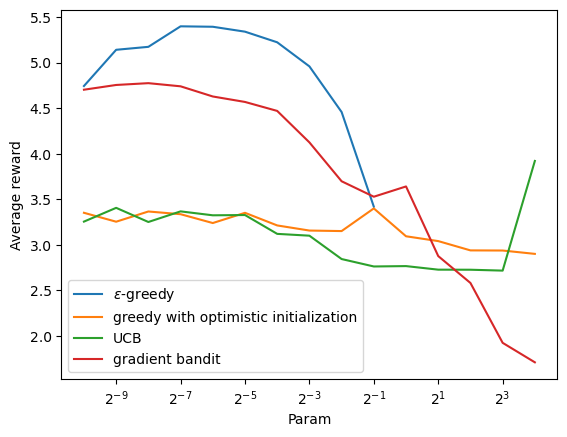

In [8]:
plt.xlabel("Param")
plt.ylabel("Average reward")
plt.semilogx(cndt, np.array(performance_log).transpose(), label=["$\epsilon$-greedy","greedy with optimistic initialization","UCB","gradient bandit"], base=2)
plt.legend()
plt.savefig("e2-11_nonstationary.png")
#plt.show()